# TSSL Lab 2 - Structural model, Kalman filtering and EM
We will continue to work with the Global Mean Sea Level (GMSL) data that we got acquainted with in lab 1. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

In this lab we will analyse this data using a structural time series model. We will first set up a model and implement a Kalman filter to infer the latet states of the model, as well doing long-term prediction. We will then implement a disturbance smoother and an expectation maximization algorithm to tune the parameters of the model. 

- This lab assignment was complete by:
    - Juliana Gouveia de Sá Couto, julgo420
    - Mohamed Ali, mohal954

We load a few packages that are useful for solving this lab assignment.

In [1]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

plt.rcParams["figure.figsize"] = (12,8)  # Increase default size of plots

## 2.1 Setting up a structural state space model

We start by loading and plotting data to reming ourselves what it looks like.

In [2]:
data = pandas.read_csv('sealevel.csv', header = 0)

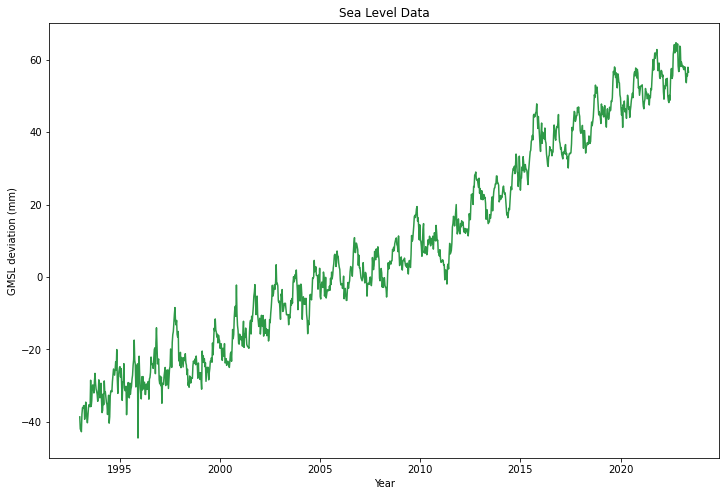

In [3]:
y = data['GMSL'].values
u = data['Year'].values

ndata = len(y)

plt.plot(u,y,color= '#2E9947')
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')
plt.title('Sea Level Data')
plt.show()

In this lab we will use a structural time series model to analys this data set. Specifically, we assume that the data $\{y_t\}_{t\geq 1}$ is generated by

\begin{align}
    y_t = \mu_t + \gamma_t + \varepsilon_t
\end{align}

where $\mu_t$ is a trend component, $\gamma_t$ is a seasonal component, and $\varepsilon_t$ is an observation noise. The model is expressed using a state space representation,

\begin{align}
    \alpha_{t+1} &= T \alpha_t + R\eta_t, & \eta_t&\sim N(0,Q), \\
    y_t &= Z \alpha_t + \varepsilon_t, & \varepsilon_t&\sim N(0,\sigma_\varepsilon^2).
\end{align}

**Q0:** Let $d = \dim(\alpha_t)$ denote the _state dimension_ and $d_\eta = \dim(\eta_t)$ denote the dimension of the state noise. Then, what are the dimenisons of the matrices $T$, $R$, and $Z$ of the state space model?

<span style='color:Blue'>
    
__A0:__ The dimensions of the matrices $T$, $R$, and $Z$ in this state space model are determined by the state dimension ($d$) and the dimension of the state noise ($d_{\eta}$). Assuming that the distribution of mu is stationary and eventually converging to a constant:
- __$T$: Transition matrix__ - describes the evolution of the state ${\alpha}_t$ over time - dimension: $d$ x $d$
    - State dimension representation showing the transition from one state to another a Markov Chain Process context.
- __$R$: State noise loading matrix__ - specifies how the state noise ${\eta}^t$ affects the state ${\alpha}_t$ - dimension: $d$ x $d_{\eta}$
- __$Z$: Observation matrix__ - relates the state vector ${\alpha}_t$ to the observed data $y_t$ - dimension: 1 x  $d$
</span>

**Q1:** Create the state space matrices $T_{[\mu]}$, $R_{[\mu]}$, and $Z_{[\mu]}$ corresponding to the trend component $\mu_t$. We assume a local linear trend (that is, of order $k=2$). 

_Hint:_ Use **2-dimensional** `numpy.ndarray`s of the correct sizes to represent all the matrices.

<span style='color:Blue'>
    
__A1:__ In a local linear trend model of order k = 2, the state vector ${\alpha}_t$ typically consists of two components: the level ($l_t$) and the slope ($b_t$).
- __𝑇[𝜇]: Transition matrix__ - evolution of the level and slope over time - dimension: 2 × 2
- __𝑅[𝜇]: State noise loading matrix__ - specifies how the state noise affects the level and slope - dimension: 2 × 1
- __𝑍[𝜇]: Observation matrix__ - relates the state vector (level and slope) to the observed data - dimension: 1 × 2
    
$$T =
\left [
\begin{matrix}
2 & -1 \\
1 & 0
\end{matrix}
\right ]
$$

$$R =
\left [
\begin{matrix}
1 \\
0
\end{matrix}
\right ]
$$

$$Z =
\left [
\begin{matrix}
1 & 0
\end{matrix}
\right ]
$$
</span>

In [4]:
d_mu = 2

T_mu = np.array([[2, -1], [1, 0]])
R_mu = np.array([[1], [0]])
Z_mu = np.array([[1, 0]])

**Q2:** There is a yearly seasonal pattern present in the data. What should we set the periodicity $s$ of the seasonal component to, to capture this pattern?

_Hint:_ Count the average number of observations per (whole) year and round to the closest integer.

<span style='color:Blue'>
    
__A2:__ To capture the yearly seasonal pattern present in the data, the periodicity (s) of the seasonal component should be set to the number of observations per whole year. Indeed, as the time between observations is about 10 days and knowing that the year has 365 days, an __s = 37__ represents a periodicity of 370 days which is approximately one whole year.
</span>

In [5]:
# from collections import Counter
# We extract only the year from the date column
data['Year_only'] = data['Year'].astype(int)
count_per_year = data['Year_only'].value_counts()
count_per_year = count_per_year[count_per_year >= 36]

s = round(count_per_year.mean())
# Print the calculated periodicity 's'
print("Periodicity (s) for the seasonal component:", s)

Periodicity (s) for the seasonal component: 37


**Q3:** What is the _state dimension_ of a seasonal component with periodicity $s$? That is, how many states are needed in the corresponding state space representation?

<span style='color:Blue'>
    
__A3:__ A seasonal component with a periodicity of s has a state dimension of s-1. In other words, in the corresponding state space representation, it will be needed s-1 states to capture the seasonal pattern.

- A recurrent pattern that happens on a recurring basis is referred to as a seasonal component. The periodicity s describes the number of time intervals needed for the pattern to repeat itself.
- To account for the effect of the seasonal pattern when modeling a seasonal component using state space modeling, s-1 state variables are often introduced. For each of the s-1 time periods within one seasonal cycle, these states show deviations from the overall seasonal pattern.

So, in the state space representation of a seasonal component with periodicity s=37, the __state dimension = 36__.

</span>

**Q4:** Create the state space matrices $T_{[\gamma]}$, $R_{[\gamma]}$, and $Z_{[\gamma]}$ corresponding to the seasonal component $\gamma_t$. 

_Hint:_ Use **2-dimensional** `numpy.ndarray`s of the correct sizes to represent all the matrices.

<span style='color:Blue'>
    
__A4:__ For the state space matrices for the seasonal component 𝛾𝑡, where 𝑠 represents the periodicity of the seasonal component,
- __$T$_${\gamma}$: Transition matrix__ - seasonal states evolution over time - dimension: (s-1) × (s-1) = 36 x 36
- __$R$_${\gamma}$: State noise loading matrix__ - specifies how the state noise affects the seasonal states - dimension: (s-1) × 1 = 36 x 1
    - Characterizes the initial uncertainty or covariance of the seasonal states.
- __$Z$_${\gamma}$: Observation matrix__ - relates the seasonal state vector to the observed data - dimension: 1 × (s-1) = 1 x 36
    - Specifies how the seasonal states contribute to the observed data.
</span>

In [6]:
d_gamma = s - 1

T_gamma = np.zeros((d_gamma, d_gamma))
T_gamma[0, :] = -1
T_gamma[1:, :-1] = np.eye(d_gamma - 1)

R_gamma = np.zeros((d_gamma, 1))
R_gamma[0, :] = 1

Z_gamma = np.zeros((1, d_gamma))
Z_gamma[:, 0] = 1

**Q5:** Using the matrices that you have constructed above, create the state space matrices for the complete structural time series model. Print out the shapes of the resulting system matrices and check that they correspond to what you expect (cf **Q0**).

_Hint:_ Use `scipy.linalg.block_diag` and `numpy.concatenate`.

<span style='color:Blue'>
    
__A5:__ Do the shapes of the resulting system matrices correspond to the initial expectations? __YES!__

    
__$T$: Transition matrix__
- In the model, there is a combination of the trend component (2 states) and the seasonal component (s-1 states). 
- The dimension of the transition matrix $T$ is determined by the sum of these state dimensions, which is (2 + s - 1).
- In this case, s represents the periodicity of the seasonal component (37 states), and the resulting shape of T as (39, 39) aligns with your expectations.

__$R$: State noise loading matrix__
- The dimensions of $R$ depend on the state dimension $d$ and the dimension of the state noise $d{\eta}$.
- In this case, there are a total of (2 + s - 1) states and 2 dimensions for state noise. 
- So, the shape of $R$ as (39, 2) corresponds to the expected dimensions, where each row of $R$ relates to the corresponding state's noise loading.

__$Z$: Observation matrix__
- The dimensions of $Z$ depend on the state dimension $d$.
- In this case, there is a total of (2 + s - 1) states, so the observation matrix has a row with (2 + s - 1) elements. 
- The shape of $Z$ as (1, 39) aligns with  expectations, where each element in $Z$ relates to the contribution of a specific state to the observed data.
</span>

In [7]:
T = scipy.linalg.block_diag(T_mu, T_gamma)
R = scipy.linalg.block_diag(R_mu, R_gamma)
Z = np.concatenate((Z_mu, Z_gamma), axis=1)

print("T shape:", T.shape)
print("R shape:", R.shape)
print("Z shape:", Z.shape)

T shape: (38, 38)
R shape: (38, 2)
Z shape: (1, 38)


We also need to specify the variances of the process noise $\eta_t$ and measurement noise $\varepsilon_t$. Below, we will estimate (two of) these variances from data, but for now we set them arbitrarily to get an initial model to work with.

In [8]:
# Some arbitrary noise values for now
sigma_trend = 0.01
sigma_seas = 1
sigma_eps = 1
Q = np.array([[sigma_trend**2, 0.], [0., sigma_seas**2]])  # Process noise covariance matrix

Finally, to complete the model we need to specify the distribution of the initial state. This encodes our _a priori_ belief about the actual values of the trend and seasonality, i.e., before observing any data.

**Q6:** Set up the mean vector of the initial state $a_1 = \mathbb{E}[\alpha_1]$ such that:
* The trend component starts at the first observation, $\mathbb{E}[\mu_1] = y_1$,
* The slope of the trend is _a priori_ zero in expectation, $\mathbb{E}[\mu_1 - \mu_0] = 0$,
* The initial mean of all states related to the seasonal component are zero.

Also, create an initial state covariance matrix $P_1 = \text{Cov}(\alpha_1)$ as an identity matrix of the correct dimension, multiplied with a large value (say, 100) to represent our uncertainty about the initial state.

<span style='color:Blue'>
    
__A6:__ Some remarks about the mean vector of the initial state $a_1$ and initial state covariance matrix $P_1$.
    
- __$a_1$__ vector of zeros with dimension d, where d is the total dimension of the state vector. In this case, d consists of the components for the trend and the seasonal states.

- __$P_1$__ identity matrix with dimension d×d and multiply it by a large value (e.g., 100) to represent the initial uncertainty about the state. This ensures that the initial state covariance matrix is large, indicating a high level of uncertainty about the initial state.
</span>

In [9]:
a1 = np.zeros((d_mu + s - 1, 1))

a1[0] = y[0]  # Initial level starts at the first observation
a1[1] = y[0]  # Initial slope is a priori zero in expectation

# Initialize 𝑃1 (initial state covariance matrix)
P1 = np.eye(d_mu + s - 1) * 100  # Identity matrix multiplied by 100 for uncertainty

We have now defined all the matrices etc. that make up the structural state space model. For convenience, we can create an object of the class `LGSS` available in the module `tssltools_lab2` as a container for these quantities.

In [10]:
from tssltools_lab2 import LGSS
model = LGSS(T, R, Q, Z, sigma_eps**2, a1, P1)

# help(model.get_params)

## 2.2 Kalman filtering for the structural model
Now we have the data and a model available. Next, we will turn our attention to the inference problem, which is a central task when analysing time series data using the state space framework.

State inference is the problem of estimating the unknown (latent) state variables given the data. For the time being we assume that the _model parameters_ are completely specified, according to above, and only consider how to estimate the states using the Kalman filter.

In the questions below we will treat the first $n=800$ time steps as training data and the remaining $m$ observations as validation data. 

In [11]:
n = 800
m = ndata-n


**Q7:** Complete the Kalman filter implementation below. The function should be able to handle missing observations, which are encoded as "not a number", i.e. `y[t] = np.nan` for certain time steps `t`. 

_Hint:_ The Kalman filter involves a lot of matrix-matrix and matrix-vector multiplications. It turns out to be convient to store sequences of vectors (such as the predicted and filtered state estimates) as `(d,1,n)` arrays, instead of `(d,n)` or `(n,d)` arrays. In this way the matrix multiplications will result in 2d-arrays of the correct shapes without having to use a lot of explicit `reshape`. However, clearly, this is just a matter of coding style preferences!

In [12]:
from tssltools_lab2 import kfs_res

def kalman_filter(y, model: LGSS):
    """Kalman filter for LGSS model with one-dimensional observation.

    :param y: (n,) array of observations. May contain nan, which encodes missing observations.
    :param model: LGSS object with the model specification.
    
    :return kfs_res: Container class with member variables,
        alpha_pred: (d,1,n) array of predicted state means.
        P_pred: (d,d,n) array of predicted state covariances.
        alpha_filt: (d,1,n) array of filtered state means.
        P_filt: (d,d,n) array of filtered state covariances.
        y_pred: (n,) array of means of p(y_t | y_{1:t-1})
        F_pred: (n,) array of variances of p(y_t | y_{1:t-1})
    """

    n = len(y)
    d = model.d  # State dimension
    alpha_pred = np.zeros((d, 1, n))
    P_pred = np.zeros((d, d, n))
    alpha_filt = np.zeros((d, 1, n))
    P_filt = np.zeros((d, d, n))
    y_pred = np.zeros(n)
    F_pred = np.zeros(n)

    T, R, Q, Z, H, a1, P1 = model.get_params()  # Get all model parameters (for brevity)

    for t in range(n):
        
        # Time update (predict)
        if t == 0:
            alpha_pred[:, :, t] = a1
            P_pred[:, :, t] = P1
        
        else:
            alpha_pred[:, :, t] = np.dot(T, alpha_filt[:, :, t - 1])
            P_pred[:, :, t] = np.dot(np.dot(T, P_filt[:, :, t - 1]), T.T) + np.dot(np.dot(R, Q), R.T)

        # Compute prediction of current output
        y_pred[t] = np.dot(Z, alpha_pred[:, :, t])
        F_pred[t] = np.dot(np.dot(Z, P_pred[:, :, t]), Z.T) + H
        
        
        # Measurement update (correct)    
        # Check for missing observations
        if np.isnan(y[t]):
            # Update state estimates without correction
            alpha_filt[:, :, t] = alpha_pred[:, :, t]
            P_filt[:, :, t] = P_pred[:, :, t]
       
        else:          
            K = np.dot(P_pred[:, :, t], Z.T) / F_pred[t]
            alpha_filt[:, :, t] = alpha_pred[:, :, t] + K * (y[t] - y_pred[t])
            P_filt[:, :, t] = np.dot((np.identity(d_mu + s - 1) - np.dot(K, Z)), P_pred[:, :, t])
            

    kf = kfs_res(alpha_pred, P_pred, alpha_filt, P_filt, y_pred, F_pred)
    return kf

**Q8:** Use the Kalman filter to infer the states of the structural time series applied to the sealevel data. Run the filter on the training data (i.e., first $n=800$ time steps), followed by a long-range prediction of $y_t$ for the remaining time points. 

Generate a plot which shows:
1. The data $y_{1:n+m}$,
2. The one-step predictions $\hat y_{t|t-1} \pm 1 $ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The long-range predictions $\hat y_{t|n} \pm 1 $ standard deviation for the validation data, i.e., $t= n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using `plt.axvline(x=u[n])`.

_Hint:_ It is enough to call the `kalman_filter` function once. Make use of the missing data functionality!

In [13]:
y_kalman = np.copy(y)
y_kalman[n:] = np.nan

# Perform Kalman filtering on the entire dataset
kalman_result = kalman_filter(y_kalman, model)

# Confidence Interval (+- 1 Standard Deviation) 
upper_CI = kalman_result.y_pred + np.sqrt(kalman_result.F_pred)
lower_CI = kalman_result.y_pred - np.sqrt(kalman_result.F_pred)

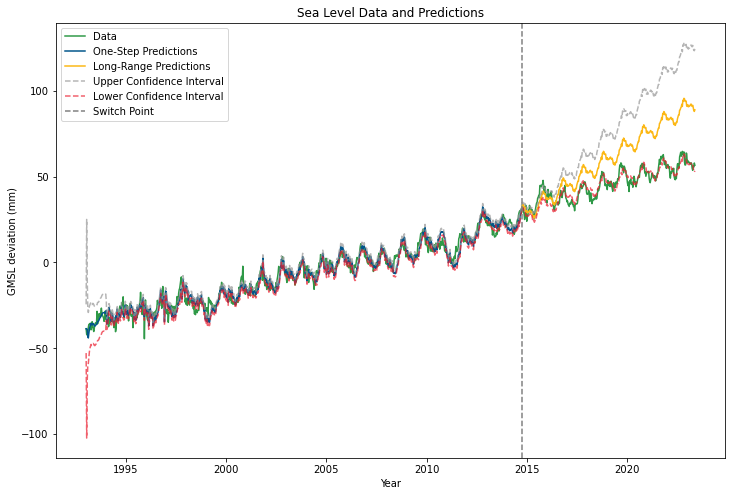

In [14]:
# Create the plot
plt.plot(u, y, label = "Data", color = "#2E9947")
plt.plot(u[:n], kalman_result.y_pred[:n], label = "One-Step Predictions", color = "#00558B")
plt.plot(u[n:], kalman_result.y_pred[n:], label = "Long-Range Predictions", color = "#FCB815")

plt.plot(u, upper_CI, linestyle = "--", color = "#969696", label = "Upper Confidence Interval", alpha = 0.7)
plt.plot(u, lower_CI, linestyle = "--", color = "#EB1C2E", label = "Lower Confidence Interval", alpha = 0.7)

plt.axvline(x = u[n], linestyle = "--", color="gray", label="Switch Point")
plt.xlabel("Year")
plt.ylabel("GMSL deviation (mm)")
plt.title("Sea Level Data and Predictions")

plt.legend()
#plt.grid(True)
plt.show()

**Q9:** Based on the output of the Kalman filter, compute the training data log-likelihood $\log p(y_{1:n})$.

<span style='color:Blue'>
    
__A9:__ There is no "ideal" value or predefined range for the log-likelihood values itself - it is applied to determine how well a specific set of model parameters fits the observed data.

- __Higher Log-Likelihood:__ The model's parameters are more effective at explaining the data that have been observed. It implies that the model's underlying assumptions make the observed data more probable.

- __Lower Log-Likelihood:__ The model's parameters do not adequately explain the data. It suggests that the model makes the observed data less likely.
    
The log-likelihood's absolute value, however, does not offer a clear interpretation or optimum range. It is frequently used to compare several models or parameter sets. A better-fitting model might be chosen, for instance, by comparing the log-likelihoods of two competing models and selecting the one with the higher log-likelihood.

</span>

In [15]:
coeficient = -n/2 * np.log(2 * np.pi)

variance = np.sum(np.log(kalman_result.F_pred[:n]))

residual = y[:n] - kalman_result.y_pred[:n]
exponential = np.sum((residual ** 2) / kalman_result.F_pred[:n])

log_likelihood = coeficient - 1/2 * (variance + exponential)
print("Log-Likelihood for Training Data:", log_likelihood)

Log-Likelihood for Training Data: -2986.425560280413


## 2.3 Identifying the noise variances using the EM algorithm
So far we have used fixed model parameters when running the filter. In this section we will see how the model parameters can be learnt from data using the EM algorithm. Specifically, we will try to learn the variance of the state noise affecting the seasonal component as well as the variance of the observation noise,

\begin{align}
    \theta = (\sigma_\gamma^2, \sigma_\varepsilon^2).
\end{align}

For brevity, the variance of the trend component $\sigma_\mu^2$ is fixed to the value $\sigma_\mu^2 = 0.01^2$ as above. (See Appendix A below for an explanation.)

Recall that we consider $y_{1:n}$ as the training data, i.e., we will estimate $\theta$ using only the first $n=800$ observations.

**Q10:** Which optimization problem is it that the EM algorithm is designed to solve? Complete the line below!

<span style='color:Blue'>
    
__A10:__ When there are unobserved or latent variables, the maximum likelihood estimates (MLE) of the parameters of a statistical model must be found. To do this, the Expectation-Maximization (EM) procedure is used. The EM algorithm seeks to determine the MLE of the model parameters in the context of state space models such as the Local Linear Trend and Seasonal (LLTS) model or Linear Gaussian State Space (LGSS) models.
    
- _Objective:_ Maximize the log-likelihood of the observed data with respect to the model parameters.
- _Parameters:_ The parameters to be estimated, denoted as θ.
- _Log-Likelihood Function:_ The log-likelihood function L(θ) represents the probability of observing the data given the model and the parameters θ.
- _Latent Variables:_ In state space models, there are typically unobserved or latent variables, which are the hidden states of the system. These latent variables are denoted as α.


__1. Expectation Step (E-step):__ In this step, the EM algorithm computes the expected value of the complete data log-likelihood with respect to the conditional distribution of the latent variables given the observed data and the current parameter estimates.

__2. Maximization Step (M-step):__ In this step, the algorithm maximizes the expected complete data log-likelihood with respect to the model parameters θ to obtain updated parameter estimates θ'.

__3. Iterative Process:__ The EM algorithm iterates between the E-step and the M-step until convergence is reached.

__4. Objective Function:__ The EM algorithm aims to maximize the expected complete data log-likelihood, which can be viewed as maximizing the expected log-likelihood of the observed data while accounting for the uncertainty introduced by the latent variables.
    
$\hat\theta = \arg\max_{\theta} Q(\theta | \tilde\theta) = \arg\max_{\theta} \mathbb{E}[\log p_{\theta}(\alpha_{1:n}, y_{1:n}) | y_{1:n}, \tilde\theta]$
$ = const - {\frac{1}{2}} {\sum}_{t=1}^{n} log(|{\sigma}_{\epsilon}^{2}| + log(|Q|) + {{\theta}_{t|n}^{2}+Var[{\epsilon}|y_{1:n}]}{\sigma}_{{\epsilon}}^{-2} + tr [{\hat{\eta}}_{t|n} {\hat{\eta}}_{t|n}^{T} + Var[{\eta}_{t|n}|y_{1:n}Q^{-1} ]$

Where the smoothing distributions are calculated using the current parameter values $\tilde\theta$.

__Conclusion:__ The EM method is made to determine the parameter values that maximize the likelihood of observing the data while accounting for the existence of latent variables that are unobserved. By maximizing the anticipated probability of the full data, which consists of both the observable data and the latent variables, it iteratively refines parameter estimations.
    
</span>

**Q11:** Write down the updating equations on closed form for the M-step in the EM algorithm.

_Hint: Look at Exercise Session 2_

<span style='color:Blue'>

__A11:__ Our goal is to formulate an expression to update the noise variance values ${\sigma}_{\gamma}$ and ${\sigma}_{\epsilon}$ for observations and seasonality, respectively. These will be later used to optimize the model variables through the Expectation-Maximization Algorithm, which entails initializing these variables and then using the same formulas to update the variables concretization.
    
- The formulas are directly derived from the expression witten in answer A10 by first taking __partial derivatives with respect to ${\sigma}_{\gamma}$ and then with respect to ${\sigma}_{\epsilon}$__. 
- Both parameters can be calculated using straightforward formulae as a result of this approach, which allows us to effectively use them in our EM method as shown below.
- It should be noted that this solution is __extremely efficient__ because in addition to always finding the global maximum that maximises the likelihood, it does so in a non-numerical way, optimising the computational cost and never stopping at a non-optimal solution, i.e. at local maximum.
    
    
**Formulas**

$\hat{\sigma}^2_{\epsilon} = \frac{1}{n} \sum^n_{t=1} \Big[ \hat{\epsilon}^2_{t|n} + Var[\epsilon_t | y_{1:n}] \Big]$


$ \hat{\sigma}^2_{\gamma} = \frac{1}{n} \sum^n_{t=1} \Big[ \hat{\eta}_{t|n} \hat{\eta}_{t|n}^T + Var[\eta_t | y_{1:n}] \Big]$
    
</span>

To implement the EM algorithm we need to solve a _smoothing problem_. The Kalman filter that we implemented above is based only on a forward propagation of information. The _smoother_ complements the forward filter with a backward pass to compute refined state estimates. Specifically, the smoothed state estimates comprise the mean and covariances of

\begin{align}
    &p(\alpha_t \mid y_{1:n}), & t=&1,\dots,n
\end{align}

Furthermore, when implementing the EM algorithm it is convenient to work with the (closely related) smoothed estimates of the disturbances, i.e., the state and measurement noise,

\begin{align}
    &p(\eta_t \mid y_{1:n}), & t=&1,\dots,n-1 \\
    &p(\varepsilon_t \mid y_{1:n}), & t=&1,\dots,n
\end{align}

An implementation of a state and disturbance smoother is available in the `tssltools_lab2` module. You may use this when implementing the EM algorithm below.


In [16]:
from tssltools_lab2 import kalman_smoother
# help(kalman_smoother)

**Q12:** Implement an EM algorithm by completing the code below. Run the algorithm for 100 iterations and plot the traces of the parameter estimates, i.e., the values $\theta_r$, for $r = 0,\dots,100$.

_Note:_ When running the Kalman filter as part of the EM loop you should only filter the _training data_ (i.e. excluding the prediction for validation data).


In [17]:
y_train = y_kalman[:n]
num_iterations = 100

sigma_eps = 0.1
sigma_seas = 0.1

# Initilazing arrays to store theta - mean and standard deviation
theta = np.zeros((num_iterations, 2))
theta[0,] = [sigma_eps, sigma_seas]

# Expectation-Maximization Algorithm
for i in range(num_iterations):
    
    # Expection-Step: Calculate expected values of latent variables
    # Compute smoothed means and variances of εt and ηt
    # Calculate the smoothing distribution using the disturbance smoother with the current parameter value theta_k
    Q = np.array([[sigma_trend**2, 0], [0, sigma_seas]])
    model = LGSS(T, R, Q, Z, sigma_eps, a1, P1)
    kalman_result = kalman_filter(y_train, model)
    smoother_result = kalman_smoother(y_train, model, kalman_result) 
    
    # Maximization-Step: Update model parameters based on expected values
    # Update paramters based on the above equations
    sigma_eps = 1/n * sum(smoother_result.eps_hat**2 + smoother_result.eps_var)
    theta[i,0] = sigma_eps

    result = 0
    for j in range(n):
        eta_hat_squar = np.dot(smoother_result.eta_hat[:,:,j], smoother_result.eta_hat[:,:,j].T)
        cov_eta = smoother_result.eta_cov[:,:,j]
        result += eta_hat_squar + cov_eta
    
    result = result[1,1]
    sigma_seas = result / n
    theta[i,1] = sigma_seas

In [18]:
print("Sigma Epsilon Estimation: ", round(sigma_eps, 4))
print("Sigma Delta Estimation: ", round(sigma_seas, 4))

Sigma Epsilon Estimation:  8.3669
Sigma Delta Estimation:  0.0369


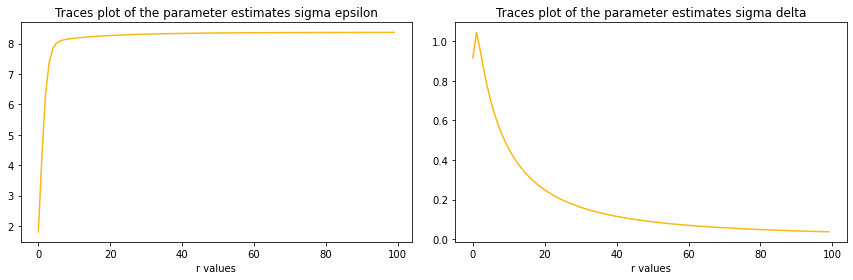

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

axes[0].plot(theta[:,0], color = '#FCB815')
axes[0].set_xlabel('r values')
axes[0].set_title('Traces plot of the parameter estimates sigma epsilon')

axes[1].plot(theta[:,1], color = '#FCB815')
axes[1].set_xlabel('r values')
axes[1].set_title('Traces plot of the parameter estimates sigma delta')

plt.tight_layout()

## 2.4 Further analysing the data
We will now fix the model according to the final output from the EM algorithm and further analyse the data using this model.

**Q13:** Rerun the Kalman filter to compute a _long range prediction for the validation data points,_ analogously to **Q8** (you can copy-paste code from that question). That is, generate a plot which shows:
1. The data $y_{1:n+m}$,
2. The one-step predictions $\hat y_{t|t-1} \pm 1 $ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The long-range predictions $\hat y_{t|n} \pm 1 $ standard deviation for the validation data, i.e., $t= n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using `plt.axvline(x=u[n])`.

Furthermore, compute the training data log-likelihood $\log p(y_{1:n})$ using the estimated model (cf. **Q9**).

In [20]:
# Updating theta values and the Q matrix
sigma_trend = 0
sigma_seas = theta[num_iterations-1,1]
sigma_eps = theta[num_iterations-1,0]
Q = np.array([[sigma_trend**2, 0.], [0., sigma_seas]])  # Process noise covariance matrix

# Updating the Linear State Spsace Model
model = LGSS(T, R, Q, Z, sigma_eps, a1, P1)

In [21]:
y_kalman = np.copy(y)
y_kalman[n:] = np.nan

# Perform Kalman filtering on the entire dataset
kalman_result = kalman_filter(y_kalman, model)

# Confidence Interval (+- 1 Standard Deviation) 
upper_CI = kalman_result.y_pred + np.sqrt(kalman_result.F_pred)
lower_CI = kalman_result.y_pred - np.sqrt(kalman_result.F_pred)

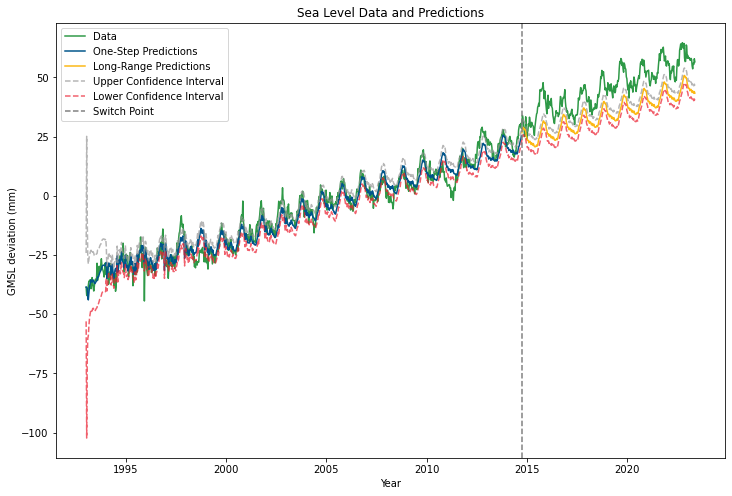

In [22]:
# Create the plot
plt.plot(u, y, label = "Data", color = "#2E9947")
plt.plot(u[:n], kalman_result.y_pred[:n], label = "One-Step Predictions", color = "#00558B")
plt.plot(u[n:], kalman_result.y_pred[n:], label = "Long-Range Predictions", color = "#FCB815")

plt.plot(u, upper_CI, linestyle = "--", color = "#969696", label = "Upper Confidence Interval", alpha = 0.7)
plt.plot(u, lower_CI, linestyle = "--", color = "#EB1C2E", label = "Lower Confidence Interval", alpha = 0.7)

plt.axvline(x = u[n], linestyle = "--", color="gray", label="Switch Point")
plt.xlabel("Year")
plt.ylabel("GMSL deviation (mm)")
plt.title("Sea Level Data and Predictions")

plt.legend()
#plt.grid(True)
plt.show()

In [23]:
coeficient = -n/2 * np.log(2 * np.pi)
variance = np.sum(np.log(kalman_result.F_pred[:n]))

residual = y[:n] - kalman_result.y_pred[:n]
exponential = np.sum((residual ** 2) / kalman_result.F_pred[:n])

log_likelihood = coeficient - 1/2 * (variance + exponential)
print("Log-Likelihood for Training Data:", log_likelihood)

Log-Likelihood for Training Data: -2345.8852176446658


Note that we can view the model for the data $y_t$ as being comprised of an underlying "signal", $s_t = \mu_t + \gamma_t$ plus observation noise $\varepsilon_t$

\begin{align}
    y_t = s_t + \varepsilon_t
\end{align}

We can obtain refined, _smoothed,_ estimates of this signal by conditioning on all the training data $y_{1:n}$. 

**Q14:** Run a Kalman smoother to compute smoothed estimates of the signal, $\mathbb{E}[s_t | y_{1:n}]$, conditionally on all the _training data_. Then, similarly to above, plot the following:
1. The data $y_{1:n+m}$,
2. The smoothed estimates $\mathbb{E}[s_t | y_{1:n}] \pm 1 $ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The predictions $\mathbb{E}[s_t | y_{1:n}] \pm 1 $ standard deviation for the validation data, i.e., $t = n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using `plt.axvline(x=u[n])`.

_Hint:_ Express $s_t$ in terms of $\alpha_t$. Based on this expression, compute the smoothed mean and variance of $s_t$ based on the smoothed mean and covariance of $\alpha_t$.

In [24]:
smoother_result = kalman_smoother(y_kalman, model, kalman_result)

res = np.zeros(n + m)
res_var = np.zeros(n + m)

for i in range(n + m):
    res[i] = np.dot(model.Z , smoother_result.alpha_sm[:,:,i] )
    res_var[i] = np.dot(model.Z, np.dot(smoother_result.V[:,:,i], model.Z.T))

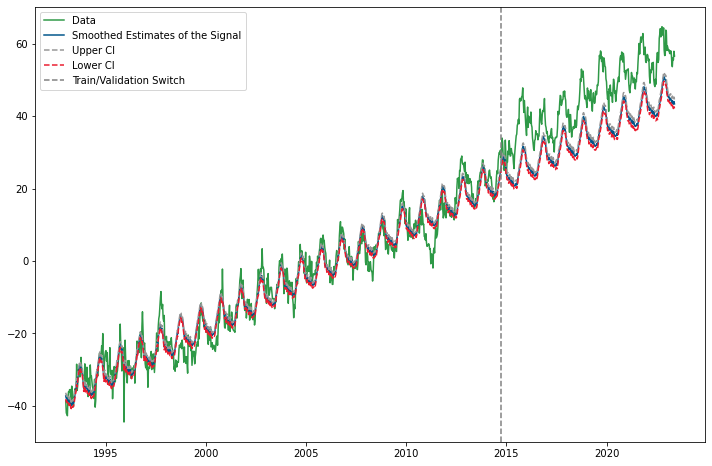

In [25]:
plt.plot(u, y, label = "Data", color = "#2E9947")
plt.plot(u, res, label = "Smoothed Estimates of the Signal", color = "#00558B")

plt.plot(u, res + np.sqrt(res_var), label = "Upper CI", linestyle = "--", color = "#969696")
plt.plot(u, res - np.sqrt(res_var), label = "Lower CI", linestyle = "--", color = "#EB1C2E")

plt.axvline(x = u[n], ls = "--", label = "Train/Validation Switch", color = "gray")

plt.legend()
plt.show()

**Q15:** Explain, using a few sentences, the qualitative differences (or similarities) between the Kalman filter predictions plotted in **Q13** and the smoothed signal estimates plotted in **Q14** for,
1. Training data points, $t \leq n$
2. Validation data points, $t > n$

<span style='color:Blue'>
    
__A15:__ The following are the qualitative variations between the Kalman filter forecasts in Q13 and the smoothed signal estimates in Q14:

    
__For Training Data Points ($t \leq n$)__
- <u>*Kalman Filter Predictions:*</u> These exhibit higher variance as the filter only incorporates the data observed before time 𝑡. It provides real-time estimates with a focus on the immediate past.
- <u>*Smoothed Signal Estimates:*</u> Benefiting from a global view of all available data, yields more accurate results with reduced variance. It considers both past and future observations, leading to refined mean curves and narrower confidence intervals.

    
__For Validation Data Points ($t >n$)__
- <u>*Kalman Filter Predictions:*</u> Based on data available up to time n, the variance rises as the filter extrapolates into the future. Widening confidence intervals show the uncertainty involved in predictions made outside of the training set.
- <u>*Smoothed Signal Estimates:*</u> In the absence of subsequent observations, reliance on filter results introduces higher variance. The Smoother, lacking additional information, produces less accurate estimates with wider confidence intervals.

__Conclusion:__ Tthe main distinction between the filter predictions and the smoothed signal estimates is that the later <u>use all available data, including both past and future observations, resulting in more provides more reliable mean curves and narrower confidence intervals</u> for both training and validation data points. The smoothed estimations are therefore very useful for forecasting and modeling purposes.
</span>

We can shed additional light on the properties of the process under study by further decomposing the signal into its trend and seasonal components.

**Q16:** Using the results of the state smoother, compute and plot the _smoothed estimates_ of the two signal components, i.e.:

1. Trend: $\hat \mu_{t|n} = \mathbb{E}[\mu_t | y_{1:n}]$ for $t = 1,\dots,n$
2. Seasonal: $\hat \gamma_{t|n} = \mathbb{E}[\gamma_t | y_{1:n}]$ for $t = 1,\dots,n$

_(You don't have to include confidence intervals here if don't want to, for brevity.)_

In [26]:
# Initialize arrays to store smoothed estimates
mu_hat = np.zeros((n + m,))
std_dev_mu = np.zeros((n + m,))

gamma_hat = np.zeros((n + m,))
std_dev_seasonal = np.zeros((n + m,))

# Compute smoothed estimates
for i in range(n + m):
    mu_hat[i] = smoother_result.alpha_sm[:d_mu, 0, i].sum()
    
    mu_variances = np.diag(smoother_result.V[:d_mu, :d_mu, i])
    mu_covariances = np.triu(smoother_result.V[:d_mu, :d_mu, i], k = 1).flatten()
    std_dev_mu[i] = np.sqrt(mu_variances.sum() + 2 * mu_covariances.sum())
    
    gamma_hat[i] = smoother_result.alpha_sm[d_mu:(d_mu+s), 0, i].sum()
    
    gamma_variances = np.diag(smoother_result.V[d_mu:(d_mu+s), d_mu:(d_mu+s), i])
    gamma_covariances = np.triu(smoother_result.V[d_mu:(d_mu+s), d_mu:(d_mu+s), i], k = 1).flatten()
    std_dev_seasonal[i] = np.sqrt(gamma_variances.sum() + 2 * gamma_covariances.sum())  

In [27]:
upper_bound_mu = mu_hat + std_dev_mu
lower_bound_mu = mu_hat - std_dev_mu

upper_bound_seasonal = gamma_hat + std_dev_seasonal
lower_bound_seasonal = gamma_hat - std_dev_seasonal

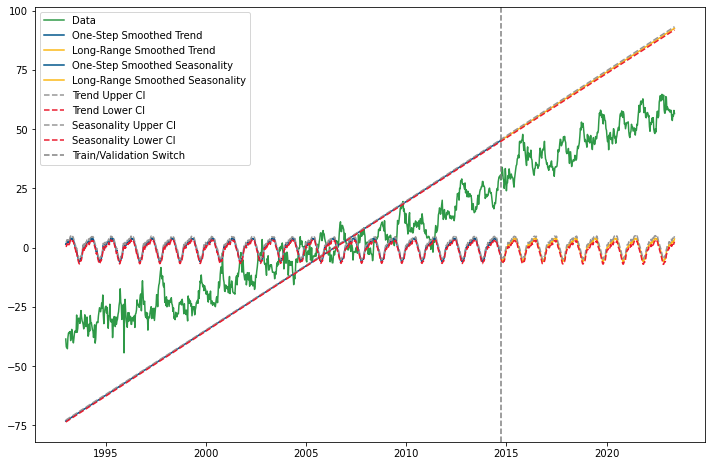

In [28]:
plt.plot(u, y, label = "Data", color = "#2E9947")

plt.plot(u[:n], mu_hat[:n], label = "One-Step Smoothed Trend", color = "#00558B")
plt.plot(u[n:], mu_hat[n:], label = "Long-Range Smoothed Trend", color = "#FCB815")

plt.plot(u[:n], gamma_hat[:n], label = "One-Step Smoothed Seasonality", color = "#00558B")
plt.plot(u[n:], gamma_hat[n:], label = "Long-Range Smoothed Seasonality", color = "#FCB815")

plt.plot(u, upper_bound_mu, label = "Trend Upper CI", linestyle = "--", color = "#969696")
plt.plot(u, lower_bound_mu, label = "Trend Lower CI", linestyle = "--", color = "#EB1C2E")

plt.plot(u, upper_bound_seasonal, label = "Seasonality Upper CI", linestyle = "--", color = "#969696")
plt.plot(u, lower_bound_seasonal, label = "Seasonality Lower CI", linestyle = "--", color = "#EB1C2E")

plt.axvline(x = u[n], ls = "--", label = "Train/Validation Switch", color = "gray")

plt.legend()
plt.show()

## 2.5 Missing data
We conclude this section by illustrating one of the key merits of the state space approach to time series analysis, namely the simplicity of handling missing data. To this end we will assume that a chunk of observations in the middle of the training data is missing.

**Q17:** Let the values $y_{t}$ for $ 300 < t \leq 400$ be missing. Modify the data and rerun the Kalman filter and smoother. Plot,
1. The Kalman filter predictions, analogously to **Q8**
2. The Kalman smoother predictions, analogously to **Q13**

Comment on the qualitative differences between the filter and smoother estimates and explain what you see (in a couple of sentences).

<span style='color:Blue'>
    
__A17:__ The following are the qualitative variations between the Kalman filter forecasts in Q13 and the smoothed signal estimates in Q14:

    
__For Training Data Points ($t \leq n$)__
- <u>*Kalman Filter Predictions:*</u> These exhibit higher variance as the filter only incorporates the data observed before time 𝑡. It provides real-time estimates with a focus on the immediate past. When estimating the missing data points, the Kalman filter seems to derail regarding the trend component while maintaining the seasonal signal.
- <u>*Smoothed Signal Estimates:*</u> Benefiting from a global view of all available data, yields more accurate results with reduced variance. It considers both past and future observations, leading to refined mean curves and narrower confidence intervals. This conclusion goes which what is observed in the graph because the missing data prediction seems to follow either the trend and seasonality.

    
__For Validation Data Points ($t >n$)__
- <u>*Kalman Filter Predictions:*</u> Based on data available up to time n, the variance rises as the filter extrapolates into the future. However, after the switch point, confidence intervals seem to maintain their distance from the prediction which shows the uncertainty involved in predictions made outside of the validation set.
- <u>*Smoothed Signal Estimates:*</u> In the absence of subsequent observations, reliance on filter results introduces higher variance. The Smoother, lacking additional information, produces less accurate estimates as the predictions are not as close to the trend, although with tight confidence intervals and accurate season modelling.

__Conclusion:__ Tthe main distinction between the filter predictions and the smoothed signal estimates is that the later <u>use all available data, including both past and future observations, resulting in more provides more reliable mean curves and narrower confidence intervals</u> for both training and validation data points. The smoothed estimations are therefore very useful for forecasting and modeling purposes.
</span>

In [29]:
y_modified = y.copy()
y_modified[300:400] = np.nan
y_visualization = y_modified.copy()
y_modified[n:] = np.nan

In [30]:
# Run the Kalman filter on the modified data
kalman_result = kalman_filter(y_modified, model)

# Confidence Interval (+- 1 Standard Deviation)
upper_CI = kalman_result.y_pred + np.sqrt(kalman_result.F_pred)
lower_CI = kalman_result.y_pred - np.sqrt(kalman_result.F_pred)

In [31]:
# Run the Kalman smoother on the modified data
smoother_result = kalman_smoother(y_modified, model, kalman_result)

res = np.zeros(n + m)
res_var = np.zeros(n + m)

for i in range(n + m):
    res[i] = np.dot(model.Z , smoother_result.alpha_sm[:,:,i] )
    res_var[i] = np.dot(model.Z, np.dot(smoother_result.V[:,:,i], model.Z.T)) + smoother_result.eps_var[i]

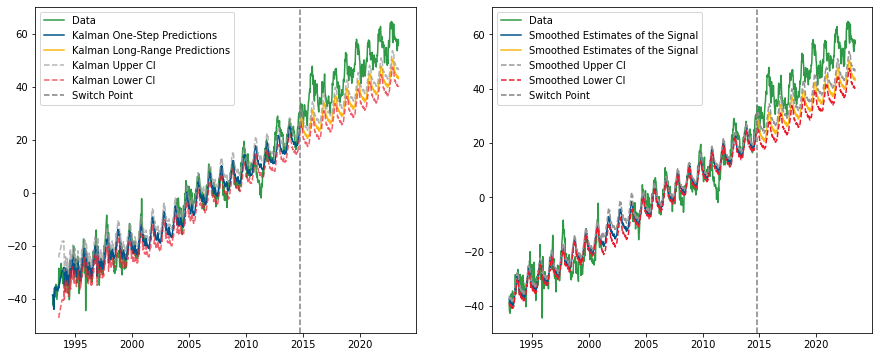

In [32]:
# Plot the Kalman filter and smoother predictions
# Create the plot
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

axes[0].plot(u, y_visualization, label = "Data", color = "#2E9947")

axes[0].plot(u[:n], kalman_result.y_pred[:n], label = "Kalman One-Step Predictions", color = "#00558B")
axes[0].plot(u[n:], kalman_result.y_pred[n:], label = "Kalman Long-Range Predictions", color = "#FCB815")

axes[0].plot(u[20:], upper_CI[20:], linestyle = "--", color = "#969696", label = "Kalman Upper CI", alpha = 0.7)
axes[0].plot(u[20:], lower_CI[20:], linestyle = "--", color = "#EB1C2E", label = "Kalman Lower CI", alpha = 0.7)

axes[0].axvline(x = u[n], linestyle = "--", color = "gray", label = "Switch Point")
axes[0].legend()

axes[1].plot(u, y_visualization, label = "Data", color = "#2E9947")

axes[1].plot(u[:n], res[:n], label = "Smoothed Estimates of the Signal", color = "#00558B")
axes[1].plot(u[n:], res[n:], label = "Smoothed Estimates of the Signal", color = "#FCB815")

axes[1].plot(u, res + np.sqrt(res_var), label = "Smoothed Upper CI", linestyle = "--", color = "#969696")
axes[1].plot(u, res - np.sqrt(res_var), label = "Smoothed Lower CI", linestyle = "--", color = "#EB1C2E")

axes[1].axvline(x = u[n], linestyle = "--", color = "gray", label = "Switch Point")
axes[1].legend()

plt.show()

## Appendix A. Why didn't we learn the trend noise variance as well?
In the assignment above we have fixed $\sigma_\mu$ to a small value. Conceptually it would have been straightforward to learn also this parameter with the EM algorithm. However, unfortunately, the maximum likelihood estimate of $\sigma_\mu$ often ends up being too large to result in accurate _long term predictions_. The reason for this issue is that the structural model

\begin{align}
    y_t = \mu_t + \gamma_t + \varepsilon_t
\end{align}

is not a perfect description of reality. As a consequence, when learning the parameters the mismatch between the model and the data is compensated for by increasing the noise variances. This results in a trend component which does not only capture the long term trends of the data, but also seemingly random variations due to a model misspecification, possibly resulting in poor _long range predictions_.

Kitagawa (Introduction to Time Series Modeling, CRC Press, 2010, Section 12.3) discusses this issue and proposes two solutions. The first is a simple and pragmatic one: simply fix $\sigma_\mu^2$ to a value smaller than the maximum likelihood estimate. This is the approach we have taken in this assignment. The issue is of course that in practice it is hard to know what value to pick, which boild down to manual trial and error (or, if you are lucky, the designer of the lab assignment will tell you which value to use!).

The second, more principled, solution proposed by Kitagawa is to augment the model with a stationary AR component as well. That is, we model

\begin{align}
    y_t = \mu_t + \gamma_t + \nu_t + \varepsilon_t
\end{align}

where $\nu_t \sim \text{AR}(p)$. By doing so, the stationary AR component can compensate for the discrepancies between the original structural model and the "true data generating process". It is straightforward to include this new component in the state space representation (how?) and to run the Kalman filter and smoother on the resulting model. Indeed, this is one of the beauties with working with the state space representation of time series data! However, the M-step of the EM algorithm becomes a bit more involved if we want to use the method to estimate also the AR coefficients of the $\nu$-component, which is beyond the scope of this lab assignment.